Some preliminary code:

In [181]:
%matplotlib inline
%load_ext Cython
import numpy as np
import cv2
from matplotlib import pyplot as plt
import skimage as sk
import skimage.morphology as skm
import itertools

def ShowImage(title,img,ctype):
  plt.figure(figsize=(20, 20))
  if ctype=='bgr':
    b,g,r = cv2.split(img)       # get b,g,r
    rgb_img = cv2.merge([r,g,b])     # switch it to rgb
    plt.imshow(rgb_img)
  elif ctype=='hsv':
    rgb = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
    plt.imshow(rgb)
  elif ctype=='gray':
    plt.imshow(img,cmap='gray')
  elif ctype=='rgb':
    plt.imshow(img)
  else:
    raise Exception("Unknown colour type")
  plt.axis('off')
  plt.title(title)
  plt.show()

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


For reference, here's your original image:

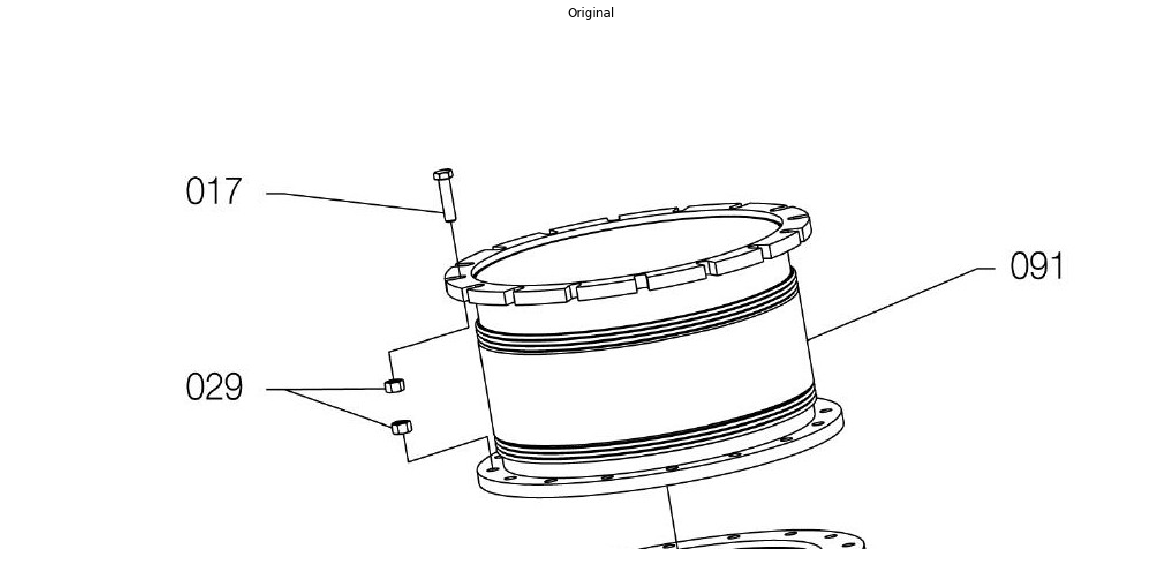

In [182]:
#Read in image
img         = cv2.imread('part.jpg')
ShowImage('Original',img,'bgr')

# Identifying Numbers

To simplify things, we'll want to classify pixels as being either on or off. We can do so with thresholding. Since our image contains two clear classes of pixels (black and white), we can use [Otsu's method](https://en.wikipedia.org/wiki/Otsu%27s_method). We'll invert the colour scheme since the libraries we're using consider black pixels boring and white pixels interesting.

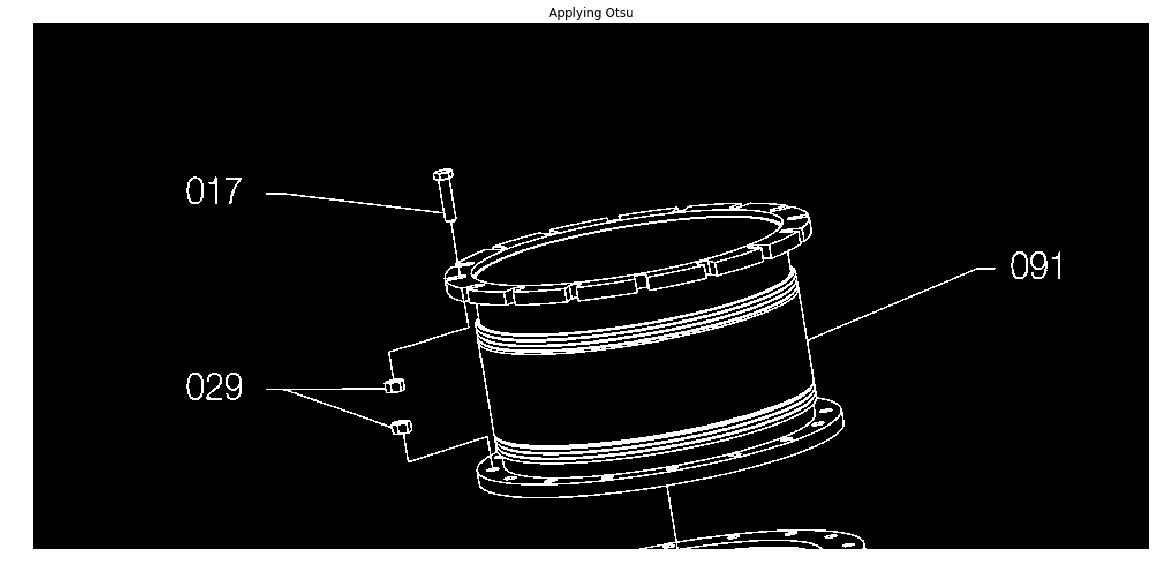

array([  0, 255], dtype=uint8)

In [183]:
#Convert image to grayscale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#Apply Otsu's method to eliminate pixels of intermediate colour
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

ShowImage('Applying Otsu',thresh,'gray')

#Verify that pixels are either black or white and nothing in between
np.unique(thresh)

Our strategy will be to locate numbers and then follow the line(s) near them to parts and then to label those parts. Since, conveniently, all of the Arabic numerals are formed from contiguous pixels, we can start by finding the connected components.

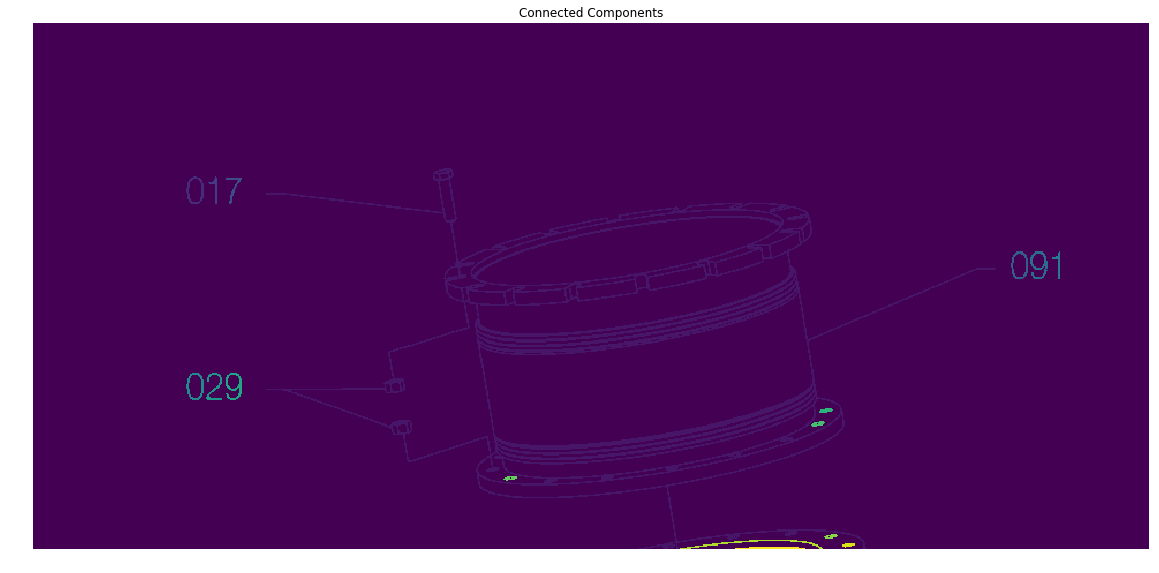

In [184]:
ret, components = cv2.connectedComponents(thresh)
#Each component is a different colour
ShowImage('Connected Components', components, 'rgb')

We can then filter the connected components to find the numbers by filtering for dimension. Note that this is not a super robust method of doing this. A better option would be to use character recognition, but this is left as an exercise to the reader :-)

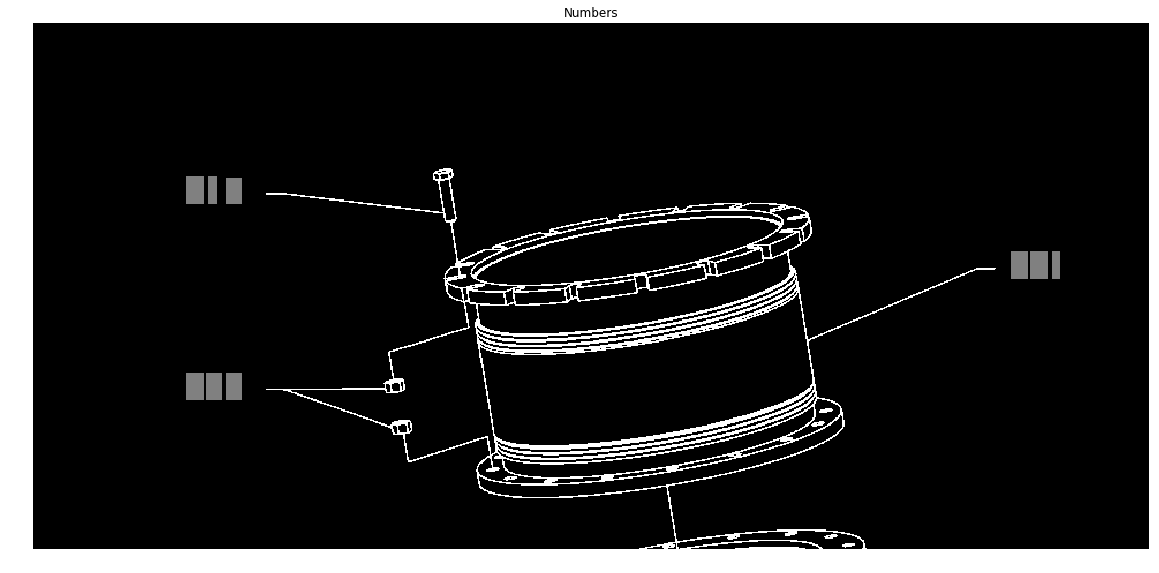

In [185]:
class Box:
    def __init__(self,x0,x1,y0,y1):
        self.x0, self.x1, self.y0, self.y1 = x0,x1,y0,y1
    def overlaps(self,box2,tol):
        if self.x0 is None or box2.x0 is None:
            return False
        return not (self.x1+tol<=box2.x0 or self.x0-tol>=box2.x1 or self.y1+tol<=box2.y0 or self.y0-tol>=box2.y1)
    def merge(self,box2):
        self.x0 = min(self.x0,box2.x0)
        self.x1 = max(self.x1,box2.x1)
        self.y0 = min(self.y0,box2.y0)
        self.y1 = max(self.y1,box2.y1)
        box2.x0 = None #Used to mark `box2` as being no longer valid. It can be removed later
    def dist(self,x,y):
        #Get center point
        ax = (self.x0+self.x1)/2
        ay = (self.y0+self.y1)/2
        #Get distance to center point
        return np.sqrt((ax-x)**2+(ay-y)**2)
    def good(self):
        return not (self.x0 is None)

def ExtractComponent(original_image, component_matrix, component_number):
    """Extracts a component from a ConnectedComponents matrix"""
    #Create a true-false matrix indicating if a pixel is part of a particular component
    is_component = component_matrix==component_number
    #Find the coordinates of those pixels
    coords = np.argwhere(is_component)

    # Bounding box of non-black pixels.
    y0, x0 = coords.min(axis=0)
    y1, x1 = coords.max(axis=0) + 1   # slices are exclusive at the top

    # Get the contents of the bounding box.
    return x0,x1,y0,y1,original_image[y0:y1, x0:x1]

numbers_img = thresh.copy() #This is used purely to show that we can identify numbers
numbers = []
for component in range(components.max()):
    tx0,tx1,ty0,ty1,this_component = ExtractComponent(thresh, components, component)
    #ShowImage('Component #{0}'.format(component), this_component, 'gray')
    cheight, cwidth = this_component.shape
    #print(cwidth,cheight) #Enable this to see dimensions
    #Identify numbers based on aspect ratio
    if (abs(cwidth-14)<3 or abs(cwidth-7)<3) and abs(cheight-24)<3:
        numbers_img[ty0:ty1,tx0:tx1] = 128
        numbers.append(Box(tx0,tx1,ty0,ty1))
ShowImage('Numbers', numbers_img, 'gray')

We now connect the numbers into contiguous blocks by expanding their bounding boxes slightly and looking for overlaps.

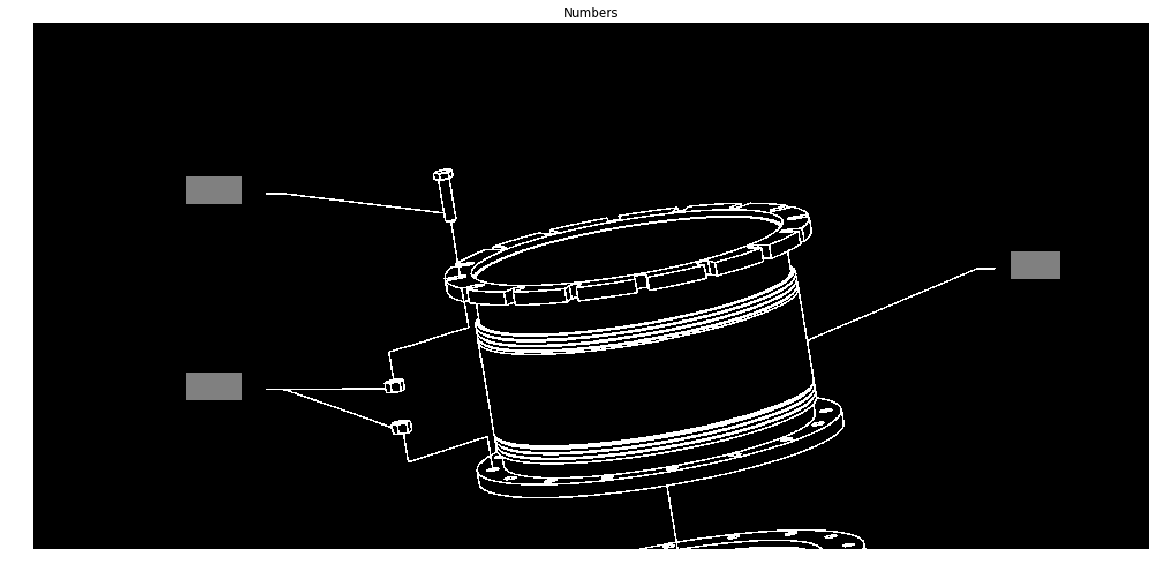

In [186]:
#This is kind of a silly way to do this, but it will work find for small quantities (hundreds)
merged=True                                       #If true, then a merge happened this round
while merged:                                     #Continue until there are no more mergers
    merged=False                                  #Reset merge indicator
    for a,b in itertools.combinations(numbers,2): #Consider all pairs of numbers
        if a.overlaps(b,10):                      #If this pair overlaps
            a.merge(b)                            #Merge it
            merged=True                           #Make a note that we've merged
numbers = [x for x in numbers if x.good()]        #Eliminate those boxes that were gobbled by the mergers

#This is used purely to show that we can identify numbers
numbers_img = thresh.copy() 
for n in numbers:
    numbers_img[n.y0:n.y1,n.x0:n.x1] = 128
    thresh[n.y0:n.y1,n.x0:n.x1] = 0 #Drop numbers from thresholded image
ShowImage('Numbers', numbers_img, 'gray')

Okay, so now we've identified the numbers! We'll use these later to identify parts.

# Identifying Arrows

Next, we'll want to figure out what parts the numbers are pointing to. To do so, we want to detect lines. The Hough transform is good for this. To reduce the number of false positives, we skeletonize the data, which transforms it into a representation which is at most one pixel wide.

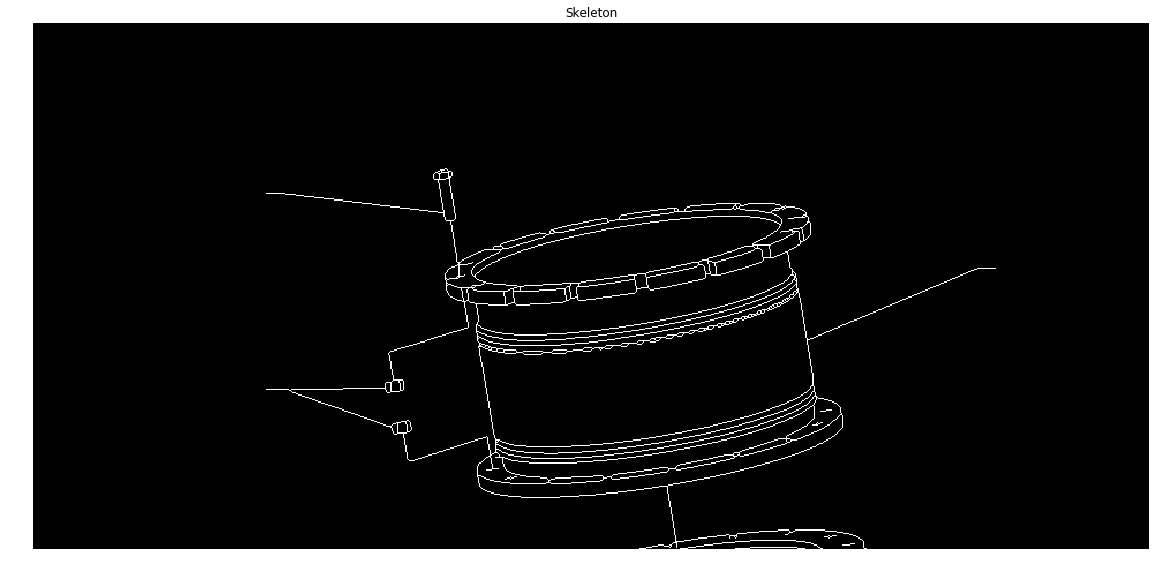

In [187]:
skel = sk.img_as_ubyte(skm.skeletonize(thresh>0))
ShowImage('Skeleton', skel, 'gray')

Now we perform the Hough transform. We're looking for one that identifies all of the lines going from the numbers to the parts. Getting this right may take some fiddling with the parameters.

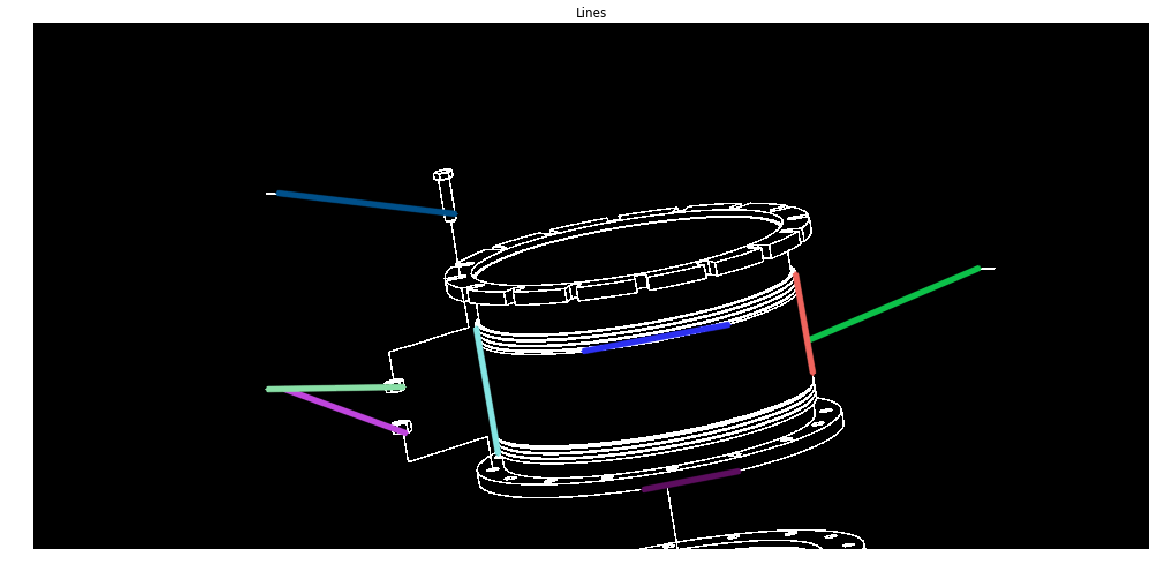

In [188]:
lines = cv2.HoughLinesP(
    skel,
    1,           #Resolution of r in pixels
    np.pi / 180, #Resolution of theta in radians
    30,          #Minimum number of intersections to detect a line
    None,
    80,          #Min line length
    10           #Max line gap
)
lines = [x[0] for x in lines]

line_img = thresh.copy()
line_img = cv2.cvtColor(line_img, cv2.COLOR_GRAY2BGR)
for l in lines:
    color = tuple(map(int, np.random.randint(low=0, high=255, size=3)))
    cv2.line(line_img, (l[0], l[1]), (l[2], l[3]), color, 3, cv2.LINE_AA)
ShowImage('Lines', line_img, 'bgr')

We now want to find the line or lines which are closest to each number and retain only these. We're essentially filtering out all of the lines which are not arrows. To do so, we compare the end points of each line to the center point of each number box.

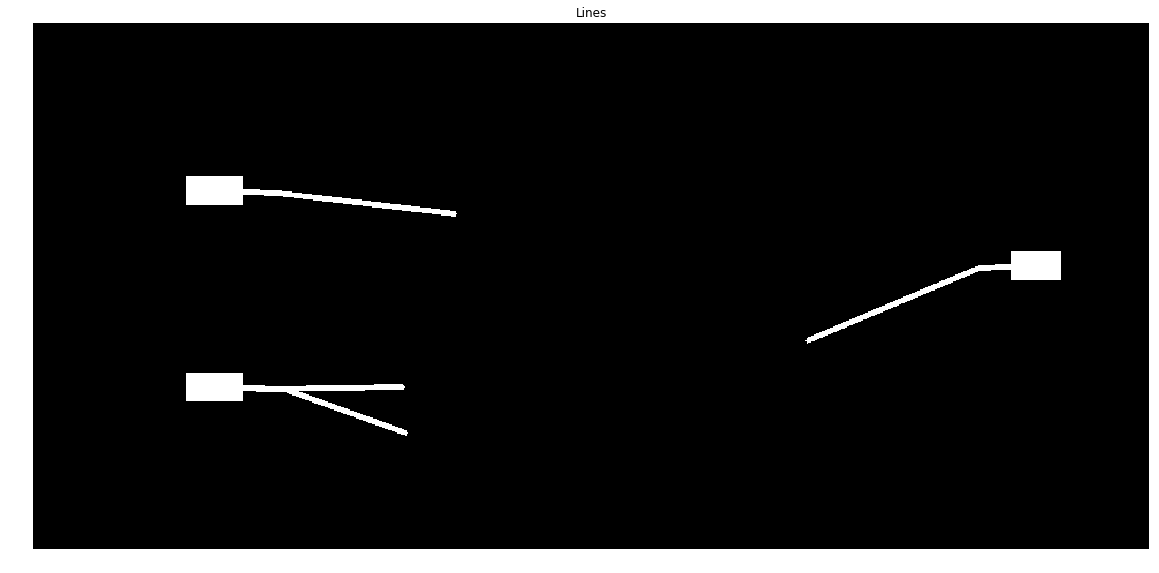

In [189]:
comp_labels = np.zeros(img.shape[0:2], dtype=np.uint8)

for n_idx,n in enumerate(numbers):
    distvals = []
    for i,l in enumerate(lines):
        #Distances from each point of line to midpoint of rectangle
        dists    = [n.dist(l[0],l[1]),n.dist(l[2],l[3])] 
        #Minimum distance and the end point (0 or 1) of the line associated with that point
        #Tuples of (Line Number, Line Point, Dist to Line Point) are produced
        distvals.append( (i,np.argmin(dists),np.min(dists)) )
    #Sort by distance between the number box and the line
    distvals = sorted(distvals, key=lambda x: x[2])
    #Include nearby lines, not just the closest one. This accounts for forking.
    distvals = [x for x in distvals if x[2]<1.5*distvals[0][2]]

    #Draw a white rectangle where the number box was
    cv2.rectangle(comp_labels, (n.x0,n.y0), (n.x1,n.y1), 1, cv2.FILLED)
    
    #Draw white lines where the arrows are
    for dv in distvals:
        l = lines[dv[0]]
        lp = (l[0],l[1]) if dv[1]==0 else (l[2],l[3])
        cv2.line(comp_labels, (l[0], l[1]), (l[2], l[3]), 1, 3, cv2.LINE_AA)
        cv2.line(comp_labels, (lp[0], lp[1]), ((n.x0+n.x1)//2, (n.y0+n.y1)//2), 1, 3, cv2.LINE_AA)
ShowImage('Lines', comp_labels, 'gray')

# Finding Parts

This part was hard! We now want to segment the parts in the image. If there was some way to disconnect the lines linking subparts together, this would be easy. Unfortunately, the lines connecting the subparts are the same width as many of the lines which constitute the parts.

To work around this, we could use a lot of logic. It would be painful and error-prone.

Alternatively, we could assume you have an expert-in-the-loop. This expert's sole job is to cut the lines connecting the subparts. This should be both easy and fast for them. Labeling everything would be slow and sad for humans, but is fast for computers. Separating things is easy for humans, but hard for computers. So we let both do what they do best.

In this case, you could probably train someone to do this job in a few minutes, so a true "expert" isn't really necessary. Just a mildly competent human.

If you pursue this, you'll need to write the expert in the loop tool. To do so, save the skeleton images, have your expert modify them, and read the skeletonized images back in. Like so.

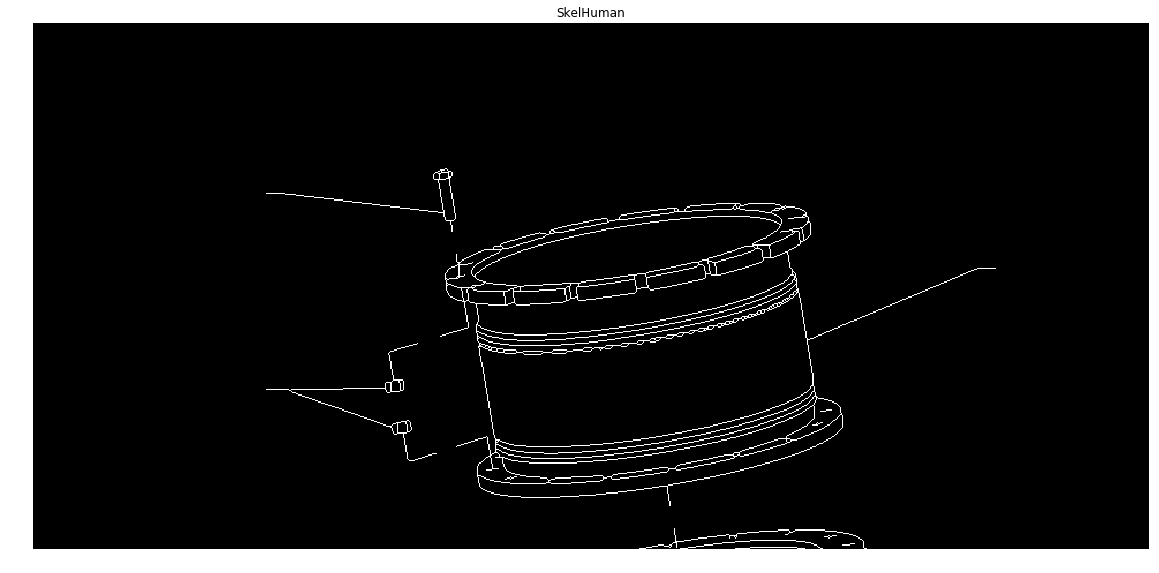

In [190]:
#Save the image, or display it on a GUI
#cv2.imwrite("/z/skel.png", skel);
#EXPERT DOES THEIR THING HERE
#Read the expert-mediated image back in
skelhuman = cv2.imread('/z/skel.png')
#Convert back to the form we need
skelhuman = cv2.cvtColor(skelhuman,cv2.COLOR_BGR2GRAY)
ret, skelhuman = cv2.threshold(skelhuman,0,255,cv2.THRESH_OTSU)
ShowImage('SkelHuman', skelhuman, 'gray')

Now that we have the parts separated, we'll eliminate as much of the arrows as possible. We've already extracted these above, so we can add them back later if we need to.

To eliminate the arrows, we'll find all of the lines that terminate in locations other than by another line. That is, we'll locate pixels which have only one neighbouring pixel. We'll then eliminate the pixel and look at its neighbour. Doing this iteratively eliminates the arrows. Since I don't know another term for it, I'll call this a _Fuse Transform_. Since this will require manipulating individual pixels, which would be _super_ slow in Python, we'll write the transform in Cython.

In [191]:
%%cython -a --cplus
import cython

from libcpp.queue cimport queue
import numpy as np
cimport numpy as np

cdef int mom2calc[3]

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
@cython.cdivision(True) 
cpdef void FuseTransform(unsigned char [:, :] image):
    # set the variable extension types
    cdef int c, x, y, nx, ny, width, height, neighbours
    cdef queue[int] q

    # grab the image dimensions
    height = image.shape[0]
    width  = image.shape[1]
    
    cdef int dx[8]
    cdef int dy[8]
    
    #Offsets to neighbouring cells
    dx[:] = [-1,-1,0,1,1,1,0,-1]
    dy[:] = [0,-1,-1,-1,0,1,1,1]
    
    #Find seed cells: those with only one neighbour
    for y in range(1, height-1):
        for x in range(1, width-1):
            if image[y,x]==0: #Seed cells cannot be blank cells
                continue
            neighbours = 0
            for n in range(0,8):   #Looks at all neighbours
                nx = x+dx[n]
                ny = y+dy[n]
                if image[ny,nx]>0: #This neighbour has a value
                    neighbours += 1
            if neighbours==1:      #Was there only one neighbour?
                q.push(y*width+x)  #If so, this is a seed cell

    #Starting with the seed cells, gobble up the lines
    while not q.empty():
        c = q.front()
        q.pop()
        y = c//width         #Convert flat index into 2D x-y index
        x = c%width
        image[y,x] = 0       #Gobble up this part of the fuse
        neighbour  = -1      #No neighbours yet
        for n in range(0,8): #Look at all neighbours
            nx = x+dx[n]     #Find coordinates of neighbour cells
            ny = y+dy[n]
            #If the neighbour would be off the side of the matrix, ignore it
            if nx<0 or ny<0 or nx==width or ny==height:
                continue
            if image[ny,nx]>0:      #Is the neighbouring cell active?
                if neighbour!=-1:   #If we've already found an active neighbour
                    neighbour=-1    #Then pretend we found no neighbours
                    break           #And stop looking. This is the end of the fuse.
                else:               #Otherwise, make a note of the neighbour's index.
                    neighbour = ny*width+nx
        if neighbour!=-1:           #If there was only one neighbour
            q.push(neighbour)       #Continue burning the fuse

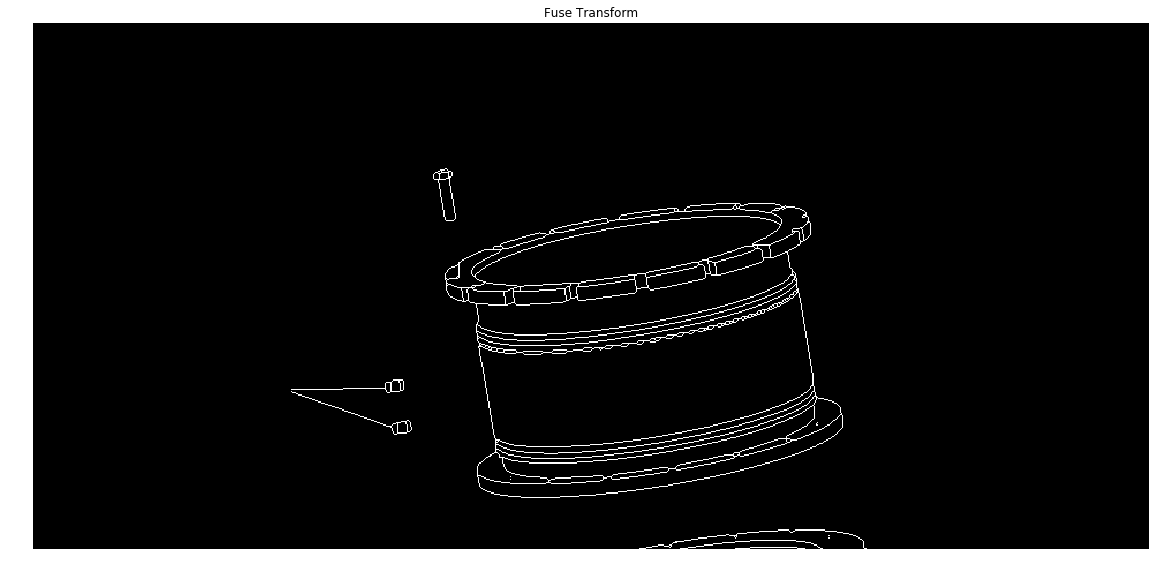

In [192]:
#Apply the Fuse Transform
skh_dilated=skelhuman.copy()
FuseTransform(skh_dilated)
ShowImage('Fuse Transform', skh_dilated, 'gray')

Now that we've eliminated all of the arrows and lines connecting the parts, we dilate the remaining pixels _a lot_.

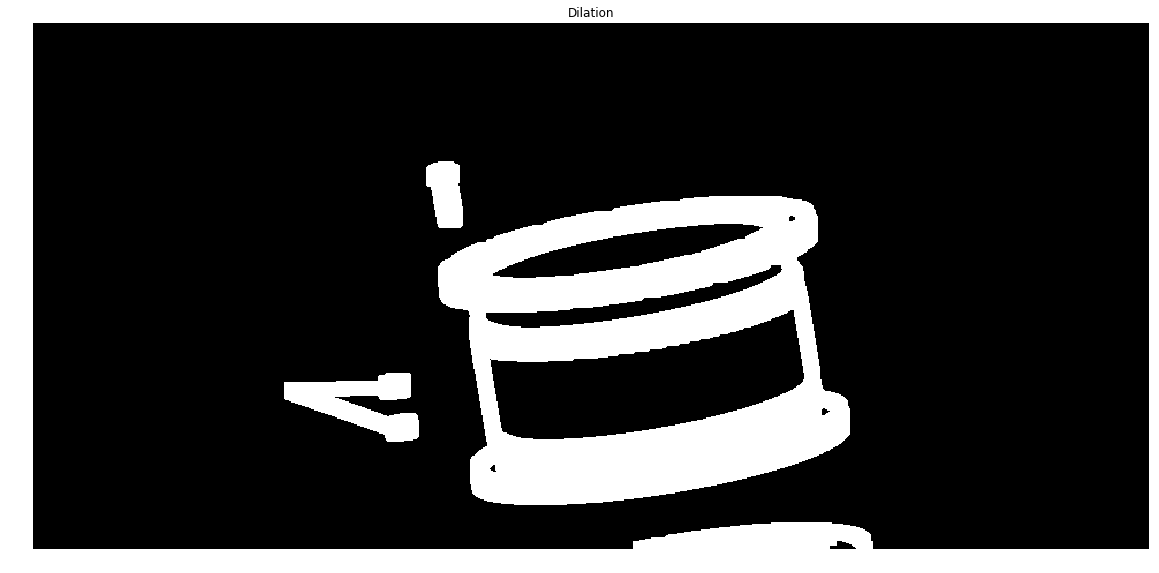

In [193]:
kernel = np.ones((3,3),np.uint8)
dilated  = cv2.dilate(skh_dilated, kernel, iterations=6)
ShowImage('Dilation', dilated, 'gray')

# Putting It All Together

And overlay the labels and arrows we segmented out earlier...

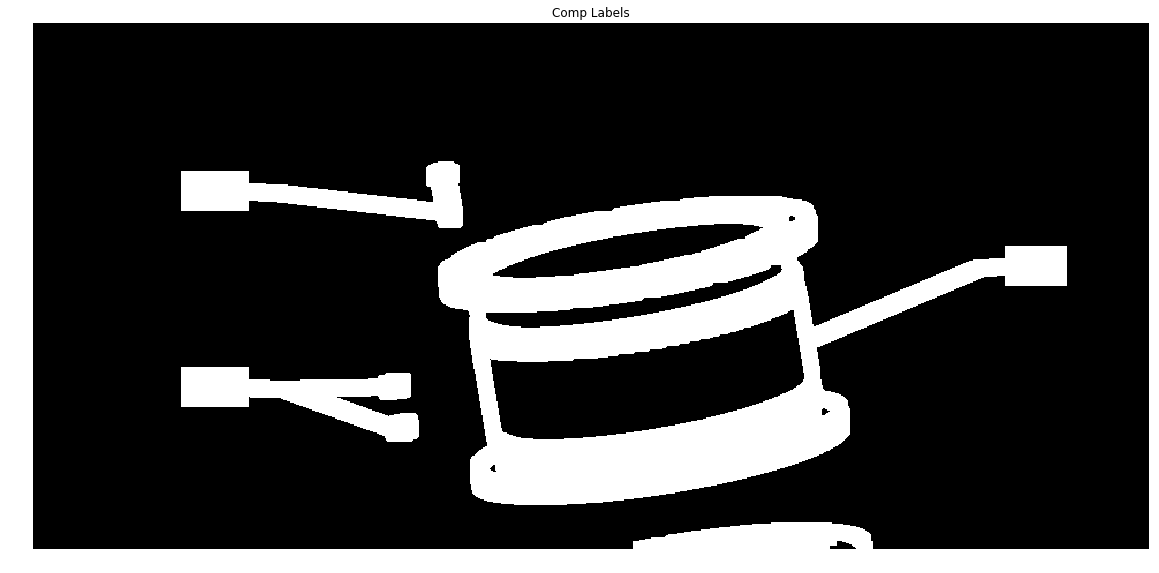

In [194]:
comp_labels_dilated  = cv2.dilate(comp_labels, kernel, iterations=5)
labels_combined = np.uint8(np.logical_or(comp_labels_dilated,dilated))
ShowImage('Comp Labels', labels_combined, 'gray')

Finally, we take the merged number boxes, component arrows, and parts and color each of them using pretty colors from [Color Brewer](http://colorbrewer2.org/#type=qualitative&scheme=Set1&n=9). We then overlay this on the original image to obtain the desired highlighting.

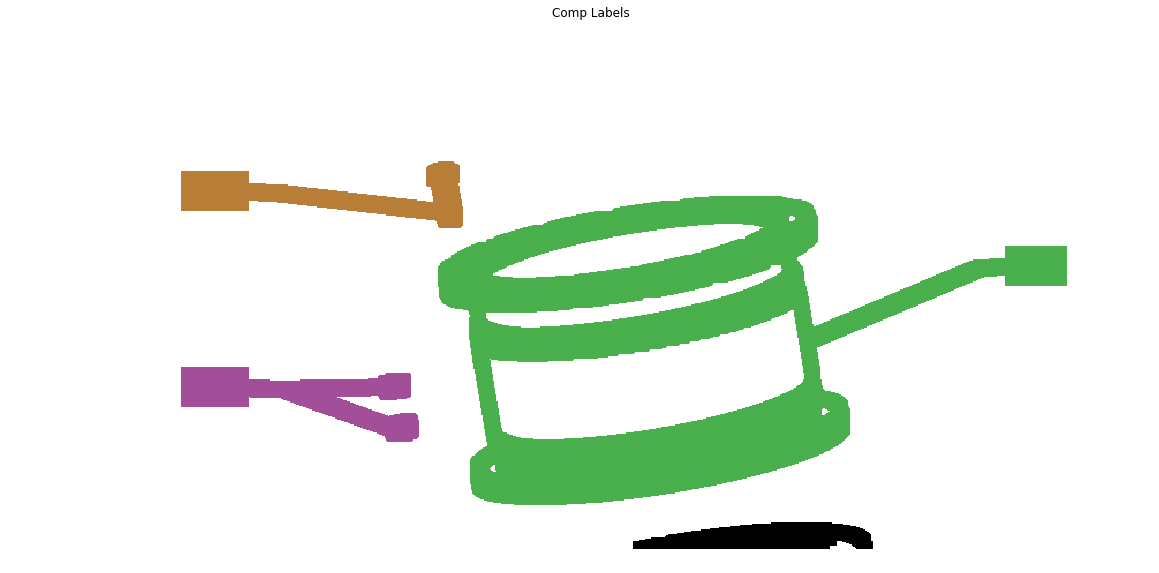

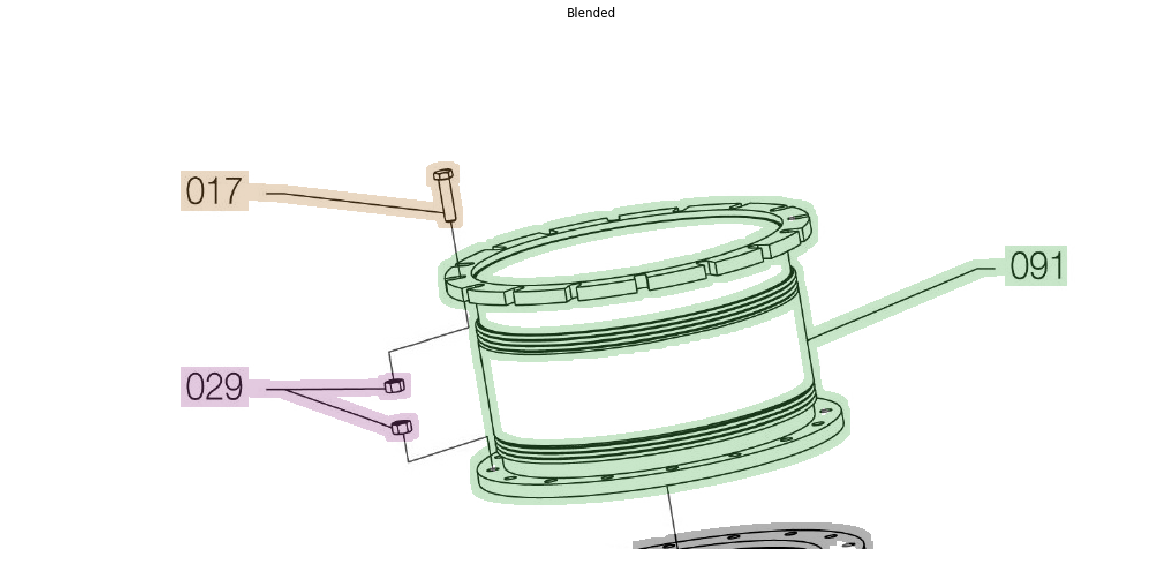

In [195]:
ret, labels = cv2.connectedComponents(labels_combined)
colormask = np.zeros(img.shape, dtype=np.uint8)
#Colors from Color Brewer
colors = [(228,26,28),(55,126,184),(77,175,74),(152,78,163),(255,127,0),(255,255,51),(166,86,40),(247,129,191),(153,153,153)]
for l in range(labels.max()):
    if l==0: #Background component
        colormask[labels==0] = (255,255,255)
    else:
        colormask[labels==l] = colors[l]
ShowImage('Comp Labels', colormask, 'bgr')
blended = cv2.addWeighted(img,0.7,colormask,0.3,0)
ShowImage('Blended', blended, 'bgr')